In [1]:
import os
# Changing the working directory
os.chdir('../..')
os.getcwd()

'/home/javiermunoz/Universidad/MasterBDyDS/TFM/TFM_DSBD'

In [32]:
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

from tensorflow.python.util import deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False

import tensorflow as tf
gpu_devices = tf.config.experimental.list_physical_devices("GPU")
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc("figure", figsize=(15, 5))

import os
from src.plot_utils import plot_history
import numpy as np

In [3]:
gpu_devices

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
from src.config import DATA_PATH, SPLITS
import pathlib

In [5]:
subset_size = 10
subset = f"subset_{subset_size}_lsa_64"

In [6]:
subset_paths = {}
for sp in SPLITS:
    subset_paths[sp] = pathlib.Path(os.path.join(DATA_PATH, subset, sp))

## 2. Loading Video Dataset

https://www.tensorflow.org/tutorials/load_data/video

In [7]:
from src.load_dataset_aux import frames_from_video_file, to_gif
from src.frame_generator import FrameGenerator
import tensorflow as tf

In [8]:
fg = FrameGenerator(subset_paths['train'], 10, training=True)

frames, label = next(fg())
print(f"Shape: {frames.shape}")
print(f"Label: {label}")

Shape: (10, 224, 224, 3)
Label: 7


In [9]:
n_frames = 10
batch_size = 6

# We specify the shape of the output, such as, the Generator will produce a tuple of both
# videos, class, where the videos will have 3 channels, and the rest of dimensions will remain the same.
#   VideoShape -> (F, H, W, C)
output_signature = (tf.TensorSpec(shape=(None, None, None, 3), dtype=tf.float32),
                    tf.TensorSpec(shape=(), dtype=tf.int16))

train_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['train'], n_frames, training=True),
                                          output_signature=output_signature)
# Also, we batchify the data, so the training process is not as memory consuming as if the whole dataset was 
# loaded into memory.
# VideoShape -> (B, F, H, W, C)
# train_ds = train_ds.batch(batch_size)
train_ds = train_ds.batch(batch_size)

# We reproduce this process for the validation and test splits too.
val_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['val'], n_frames),
                                        output_signature=output_signature)

val_ds = val_ds.batch(batch_size)
test_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['test'], n_frames),
                                         output_signature=output_signature)

test_ds = test_ds.batch(batch_size)

In [10]:
# Print the shapes of the data
train_frames, train_labels = next(iter(train_ds))
print(f'Shape of training set of frames: {train_frames.shape}')
print(f'Shape of training labels: {train_labels.shape}')

val_frames, val_labels = next(iter(val_ds))
print(f'Shape of validation set of frames: {val_frames.shape}')
print(f'Shape of validation labels: {val_labels.shape}')

Shape of training set of frames: (6, 10, 224, 224, 3)
Shape of training labels: (6,)
Shape of validation set of frames: (6, 10, 224, 224, 3)
Shape of validation labels: (6,)


In [11]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)

# 3. Model definition and Training

In [12]:
tf.keras.backend.clear_session()  

Input layer

In [13]:
# Construct the input layer with no definite frame size.
inputs = tf.keras.layers.Input(shape=(None, *train_frames.shape[2:]))
# Reescale the values of the pixels (per frame)
inputs_rescaled = tf.keras.layers.Rescaling(scale=255)(inputs)

Auxiliary branch

In [17]:
# We will construct 1 `ConvLSTM2D` layer with batch normalization,
x_aux = tf.keras.layers.ConvLSTM2D(filters=8,
                           kernel_size=(3, 3),
                           strides=(2,2),
                           stateful=False,
                           return_sequences=False,
                           activation="tanh")(inputs_rescaled)
x_aux = tf.keras.layers.BatchNormalization()(x_aux)
x_aux = tf.keras.layers.Conv2D(filters=16,
                                 kernel_size=(3,3),                       
                                 strides=(1,1))(x_aux)
x_aux = tf.keras.layers.BatchNormalization()(x_aux)
x_aux = tf.keras.layers.Dropout(0.2)(x_aux)
x_aux = tf.keras.layers.Conv2D(filters=8,
                                 kernel_size=(3,3),                       
                                 strides=(1,1))(x_aux)
res_aux = tf.keras.layers.BatchNormalization()(x_aux)

### Main Branch

In [18]:

# We will construct 3 `ConvLSTM2D` layers with batch normalization,
x_main = tf.keras.layers.ConvLSTM2D(filters=8,
                                    kernel_size=(3, 3),
                                    strides=(1,1),
                                    stateful=False,
                                    return_sequences=True,
                                    activation="tanh")(inputs_rescaled)
x_main = tf.keras.layers.BatchNormalization()(x_main)
x_main = tf.keras.layers.Dropout(0.2)(x_main)
x_main = tf.keras.layers.ConvLSTM2D(filters=8,
                                    kernel_size=(3, 3),
                                    strides=(1,1),
                                    stateful=False,
                                    return_sequences=True,
                                    activation="tanh")(x_main)
x_main = tf.keras.layers.BatchNormalization()(x_main)
x_main = tf.keras.layers.ConvLSTM2D(filters=16,
                                    kernel_size=(3, 3),
                                    strides=(2,2),
                                    stateful=False,
                                    return_sequences=False,
                                    activation="tanh")(x_main)
x_main = tf.keras.layers.BatchNormalization()(x_main)
x_main = tf.keras.layers.Dropout(0.2)(x_main)
x_main = tf.keras.layers.Conv2D(filters=8,
                               kernel_size=(3,3),                       
                               strides=(1,1))(x_main)
x_main = tf.keras.layers.BatchNormalization()(x_main)
x_add = tf.keras.layers.Add()([x_main, res_aux])
x_add = tf.keras.layers.Conv2D(filters=16,
                               kernel_size=(3, 3),                       
                               strides=(1,1))(x_add)

x_add = tf.keras.layers.GlobalMaxPooling2D()(x_add)
outputs = tf.keras.layers.Dense(units=10, activation='softmax')(x_add)

model = tf.keras.Model(inputs, outputs)

In [19]:
frames, label = next(iter(train_ds))
model.build(frames)

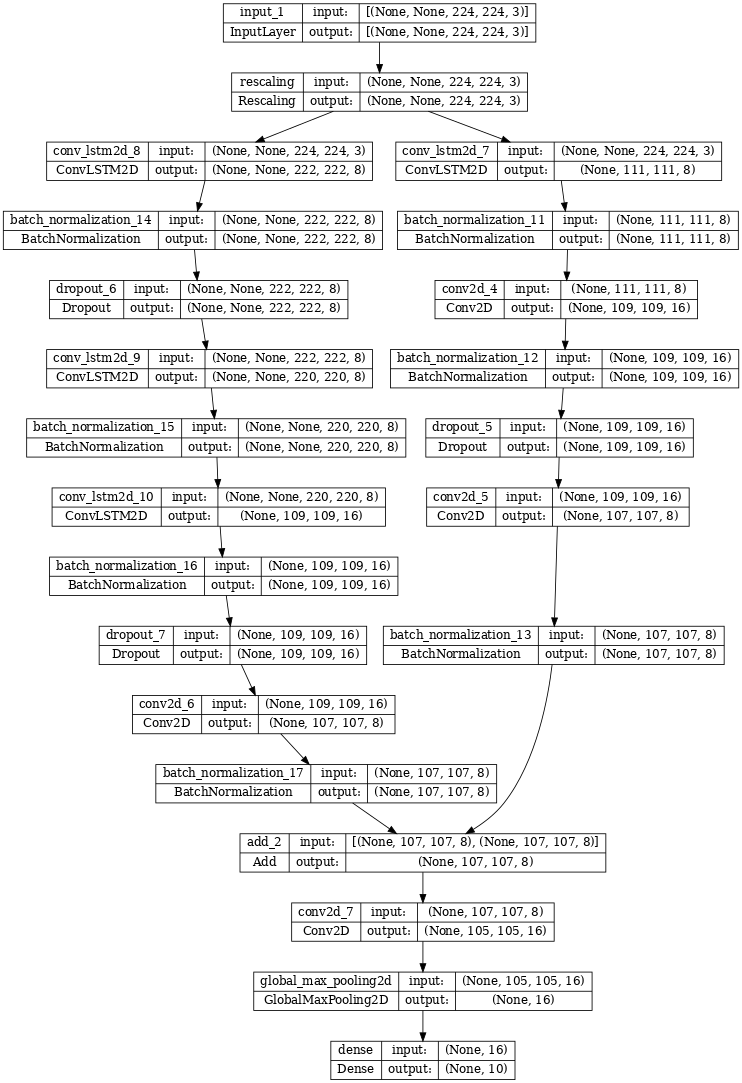

In [20]:
# Visualize the model
tf.keras.utils.plot_model(model, expand_nested=True, dpi=60, show_shapes=True)

In [21]:
model.compile(
    loss=tf.keras.losses.sparse_categorical_crossentropy, 
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-03),
    metrics=['accuracy']
)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, 224,   0           []                               
                                224, 3)]                                                          
                                                                                                  
 rescaling (Rescaling)          (None, None, 224, 2  0           ['input_1[0][0]']                
                                24, 3)                                                            
                                                                                                  
 conv_lstm2d_8 (ConvLSTM2D)     (None, None, 222, 2  3200        ['rescaling[0][0]']              
                                22, 8)                                                        

In [22]:
# CReate a customized callback so when val_acc > 94% it stops training
from keras.callbacks import EarlyStopping, ModelCheckpoint

bst_model_path = "src/convlstm/bestmodels/best_stateless_{epoch:02d}_{val_accuracy:.2f}_model.h5"

class MyThresholdCallback(tf.keras.callbacks.Callback):
    def __init__(self, threshold):
        super(MyThresholdCallback, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None): 
        val_acc = logs["accuracy"]
        if val_acc >= self.threshold:
            self.model.stop_training = True

# Define some callbacks to improve training.
early_loss_stopping = EarlyStopping(monitor="loss", patience=15)
early_acc_stopping = EarlyStopping(monitor="accuracy", patience=15)
mod_ckpoint = ModelCheckpoint(filepath = bst_model_path, 
                              save_best_only=True, 
                              monitor="val_accuracy",
                              mode="max")

callbacks=[
    early_loss_stopping,
    early_acc_stopping,
    mod_ckpoint,
    MyThresholdCallback(threshold=0.95)
]

In [23]:
# Define modifiable training hyperparameters.
epochs = 80

# Fit the model to the training data using a generator.
history = model.fit(
    train_ds,
    epochs=epochs,
    validation_data=val_ds,
    callbacks=[callbacks],
)

Epoch 1/80
66/66 [==============================] - 67s 877ms/step - loss: 3.9084 - accuracy: 0.1168 - val_loss: 2.2857 - val_accuracy: 0.1167
Epoch 2/80
66/66 [==============================] - 39s 589ms/step - loss: 2.3126 - accuracy: 0.1294 - val_loss: 2.2547 - val_accuracy: 0.1500
Epoch 3/80
66/66 [==============================] - 39s 592ms/step - loss: 2.1196 - accuracy: 0.2107 - val_loss: 2.1873 - val_accuracy: 0.1833
Epoch 4/80
66/66 [==============================] - 40s 610ms/step - loss: 2.0346 - accuracy: 0.2589 - val_loss: 2.0776 - val_accuracy: 0.1500
Epoch 5/80
66/66 [==============================] - 39s 599ms/step - loss: 1.5785 - accuracy: 0.4239 - val_loss: 1.6735 - val_accuracy: 0.3833
Epoch 6/80
66/66 [==============================] - 39s 593ms/step - loss: 1.2681 - accuracy: 0.5406 - val_loss: 1.4219 - val_accuracy: 0.4667
Epoch 7/80
66/66 [==============================] - 40s 613ms/step - loss: 1.3532 - accuracy: 0.4898 - val_loss: 1.6445 - val_accuracy: 0.4000

In [25]:
best_model = tf.keras.models.load_model("/home/javiermunoz/Universidad/MasterBDyDS/TFM/TFM_DSBD/src/convlstm/bestmodels/best_stateless_22_0.95_model.h5")

In [35]:
best_model_epoch = np.argmax(history.history['val_accuracy'])
best_model_epoch
best_acc, best_loss, best_val_acc, best_val_loss = history.history['accuracy'][best_model_epoch], history.history['loss'][best_model_epoch], history.history['val_accuracy'][best_model_epoch], history.history['val_loss'][best_model_epoch]

(0.9289340376853943,
 0.22648096084594727,
 0.949999988079071,
 0.1958674043416977)

In [37]:
# Evaluate the model on the test data using `evaluate`
print(f"Evaluate best model on test data with the following stats:\n\tAccuracy: {best_acc}\n\tLoss: {best_loss}\n\tVal Accuracy: {best_val_acc}\n\tVal Loss: {best_val_loss}")
results = best_model.evaluate(test_ds, batch_size=batch_size)
print("test loss, test acc:", results)

Evaluate best model on test data with the following stats:
	Accuracy: 0.9289340376853943
	Loss: 0.22648096084594727
	Val Accuracy: 0.949999988079071
	Val Loss: 0.1958674043416977
8/8 [==============================] - 12s 2s/step - loss: 0.3384 - accuracy: 0.9130
test loss, test acc: [0.3383561670780182, 0.9130434989929199]


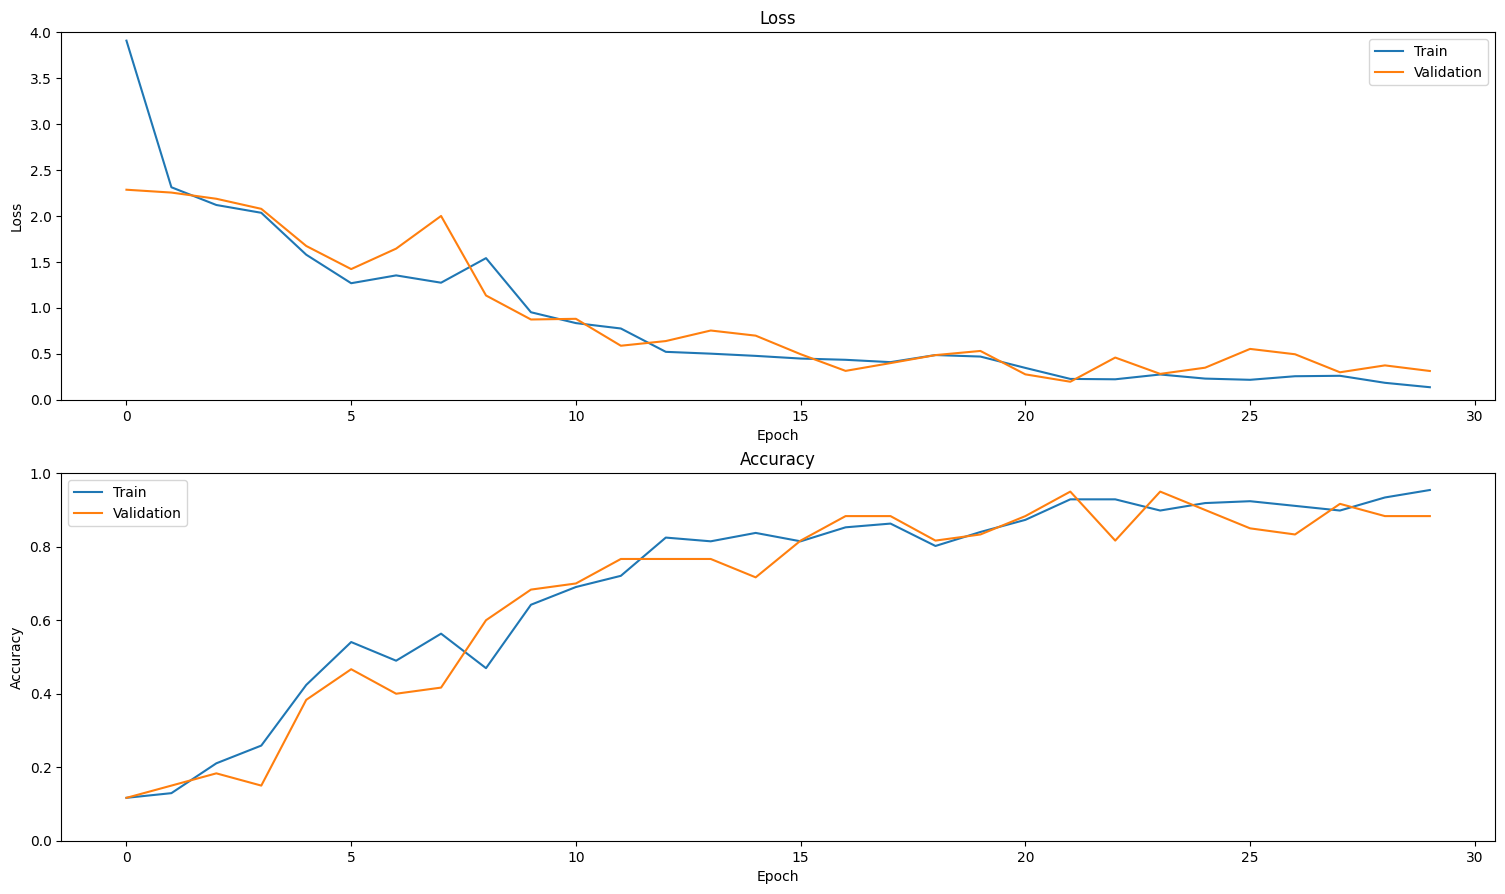

In [27]:
plot_history(history)